# Bonsai log analysis
This notebook shows you how to access your bonsai brain logs from a jupyter notebook, and carry analysis/vizualization in the notebook. Episode level and iteration level logs during training and assessment are stored on [Log Anlytics](https://docs.microsoft.com/en-us/azure/azure-monitor/platform/data-platform-logs). Logs on Azure Monitor can be probed using [KQL language](https://docs.microsoft.com/en-us/sharepoint/dev/general-development/keyword-query-language-kql-syntax-reference). The notebook uses **[Kqlmagic](https://github.com/Microsoft/jupyter-Kqlmagic)** an python library and extension for jupyter notebook [more info + more complete functionality on Kqlmagic](https://docs.microsoft.com/en-us/azure/data-explorer/kqlmagic).

## Description

Logging for bonsai service currently works for un-managed sims only (will soon be enabled for managed sims). Logging is user-enabled per specific sim's session-id. The logs are sent to a Log Analytics workspace and can be queried via KQL language. A sample to query and vizualize data in a jupyter notebook is provided here.

## Prerequisites

1. Install requirements: [enviroment.yml](https://gist.github.com/akzaidi/ed687b492b0f9e77682b0a0a83397659/)
1. Temporary manual step: If your azure subscription has not yet been registered to allow Log Analytics workspace resource provider, it needs to be registered.
    1. Determine if registering is required. <SUBCRIPTION_ID> can be found on preview.bons.ai by clicking on id/Workspace info. 
    ```
    az provider show --namespace 'Microsoft.OperationalInsights' -o table --subscription <SUBCRIPTION_ID>
    ```
    2.  If the registrationState is `Registered`, you can skip this step. If not registered, we will need to register it. This is a one-time step per subscription and user will need owner-level permission. If you don't have the appropriate permission, work with your IT admin to execute that step.

    ```
    az login
    az provider register --namespace 'Microsoft.OperationalInsights' --subscription <SUBCRIPTION_ID>
    ```
 
## Usage


1. Start an unmanaged sim and brain training as you normally would: 
    1. register a sim by launching your sim. For example `python main.py` (or through our partner sims AnyLogic or Simulink)
    1. start brain training `bonsai brain version start-training --name <BRAIN_NAME>`
    1. connect your registered sim to a brain `bonsai simulator connect --simulator-name <SIM_NAME> --brain-name <BRAIN_NAME> --version <VERSION_#> --action Train --concept-name <CONCEPT_NAME>`

3. Find the session-id of un-managed sim using Bonsai CLI: `bonsai simulator unmanaged list`

4. When you're ready to start logging:
`bonsai brain version start-logging -n <BRAIN_NAME> --session-id <SESSION_ID>`

    1.Note: A Log Analytics workspace will get created on Azure if it does not already exist
6. Temporary: You can find the Log Analytics workspace id on portal.azure.com. It will be created under your provisioned resource group `bonsai-rg-<BONSAI WORKSPACE NAME >-<WORKSPACE-ID>`

    1. Note: It might take ~5 minutes to show up if it is the first time using logging feature as the log analytics workspace gets created.
1. Logs will start populating the Log Analytics workspace 3-5 minutes after starting logging
    1. Note: if this is the first time you're using logging you may need to wait for the first episode to finish so that episode-level (EpisodeLog_CL table) logs gets created and filled with at least 1 row of data.
    1. 1. Optional: Navigate to https://ms.portal.azure.com/#blade/Microsoft_Azure_Monitoring_Logs/LogsBlade to query logs in the webUI. Sample KQL query, take 10 samples of IterationLog_CL table for the corresponding sim's session-id:
    ```KQL
    IterationLog_CL
    | where SessionId_s == <SESSION_ID>
    | take 1
    ```

## Prerequisite: Install KQL Magic (skip if already installed)
You can use the following conda [environment.yml](https://gist.github.com/akzaidi/ed687b492b0f9e77682b0a0a83397659/).

Load Kqlmagic commands

In [2]:
import sys
print(sys.path)

['/Users/alizaidi-msft/Documents/bonsai/bonsai-log-tools', '/Users/alizaidi-msft/.vscode/extensions/ms-toolsai.jupyter-2020.12.414227025/pythonFiles', '/Users/alizaidi-msft/.vscode/extensions/ms-toolsai.jupyter-2020.12.414227025/pythonFiles/lib/python', '/Users/alizaidi-msft/miniconda3/envs/nlu/lib/python37.zip', '/Users/alizaidi-msft/miniconda3/envs/nlu/lib/python3.7', '/Users/alizaidi-msft/miniconda3/envs/nlu/lib/python3.7/lib-dynload', '', '/Users/alizaidi-msft/.local/lib/python3.7/site-packages', '/Users/alizaidi-msft/miniconda3/envs/nlu/lib/python3.7/site-packages', '/Users/alizaidi-msft/miniconda3/envs/nlu/lib/python3.7/site-packages/aeosa', '/Users/alizaidi-msft/miniconda3/envs/nlu/lib/python3.7/site-packages/IPython/extensions', '/Users/alizaidi-msft/.ipython']



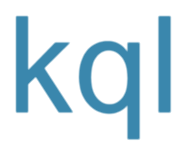

In [1]:
%reload_ext Kqlmagic
%config Kqlmagic.display_limit = 5 #limiting the number of rows displayed (full rows will still be stored)

## Login to the log analytics workspace
The `LOG_ANALYTICS_WORKSPACE_ID` is the `workspace-id` of the log analytics workspace, not your bonsai workspace

Please see **Usage** above on how to find your `LOG_ANALYTICS_WORKSPACE_ID`

In [1]:
#Login to workspace
LOG_ANALYTICS_WORKSPACE_ID = '0c26bd37-834f-43ec-80f5-21e8ba6b86bc' #this is the workdpace-id 
ALIAS = '' #optional
%kql loganalytics://code;workspace=LOG_ANALYTICS_WORKSPACE_ID;alias=ALIAS

UsageError: Line magic function `%kql` not found.


Locate the simulator you have run locally and you'd like to log. You'll need the simulator's session id.

In [67]:
!bonsai simulator unmanaged list

| Name     | Session Id              | Action   |
|----------+-------------------------+----------|
| Cartpole | 661870409_10.244.39.115 | Train    |


## Iteration and Episode Level Logs

Let's extract both iteration (IterationLog_CL table) and episode-level (EpisodeLog_CL table) logs and join them together via a KQL query. We then export the query results in a dataframe.

**Note**: if this is the first time you're using logging you may need to wait for the first episode to finish so that episode-level (EpisodeLog_CL table) logs gets created and filled with at least 1 row of data.

In [68]:
session_id = "661870409_10.244.39.115" #define sim's session_id to pull logs from
number_of_rows = 1000 # define number of rows to pull

In [69]:
%%kql
let _session_id = session_id;
let _number_of_rows = number_of_rows;
EpisodeLog_CL
| where SessionId_s == _session_id
| join kind=inner (
    IterationLog_CL
    | where SessionId_s == _session_id
    | sort by Timestamp_t desc
    | take _number_of_rows
    ) on EpisodeId_g
| project 
    Timestamp = Timestamp_t,
    EpisodeIndex = EpisodeIndex_d,
    IterationIndex = IterationIndex_d,
    BrainName = BrainName_s,
    BrainVersion = BrainVersion_d,
    SimState = parse_json(SimState_s),
    SimAction = parse_json(SimAction_s),
    Reward = Reward_d,
    CumulativeReward = CumulativeReward_d,
    Terminal = Terminal_b,
    LessonIndex = LessonIndex_d,
    SimConfig = parse_json(SimConfig_s),
    GoalMetrics = parse_json(GoalMetrics_s),
    EpisodeType = EpisodeType_s
| order by EpisodeIndex, IterationIndex

&lt;IPython.core.display.HTML object&gt;

Timestamp,EpisodeIndex,IterationIndex,BrainName,BrainVersion,SimState,SimAction,Reward,CumulativeReward,Terminal,LessonIndex,SimConfig,GoalMetrics,EpisodeType
2020-10-01 23:28:09.299000+00:00,16,13,cartpole-1,2,"{'x_position': 0.12024798204967144, 'x_velocity': 0.7911555079777586, 'angle_position': -0.18785608265610307, 'angle_velocity': -1.4029712206552598}",{'command': 0},0,-987,False,0,{},"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'success': 1, 'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1]}}",Training
2020-10-01 23:27:09.224000+00:00,16,12,cartpole-1,2,"{'x_position': 0.10056477156398944, 'x_velocity': 0.9841605242841004, 'angle_position': -0.1549835676266043, 'angle_velocity': -1.6436257514749375}",{'command': 1},0,-987,False,0,{},"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'success': 1, 'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1]}}",Training
2020-10-01 23:26:09.152000+00:00,16,11,cartpole-1,2,"{'x_position': 0.08481145290085405, 'x_velocity': 0.7876659331567697, 'angle_position': -0.12871186638466514, 'angle_velocity': -1.3135850620969585}",{'command': 1},0,-987,False,0,{},"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'success': 1, 'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1]}}",Training
2020-10-01 23:25:09.115000+00:00,16,10,cartpole-1,2,"{'x_position': 0.07298610151111154, 'x_velocity': 0.5912675694871254, 'angle_position': -0.10893647055399494, 'angle_velocity': -0.9887697915335107}",{'command': 0},0,-987,False,0,{},"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'success': 1, 'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1]}}",Training
2020-10-01 23:24:09.067000+00:00,16,9,cartpole-1,2,"{'x_position': 0.0572816717000133, 'x_velocity': 0.7852214905549123, 'angle_position': -0.08385539464078026, 'angle_velocity': -1.2540537956607338}",{'command': 1},0,-987,False,0,{},"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'success': 1, 'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1]}}",Training


&lt;IPython.core.display.HTML object&gt;

al&#39;: False, &#39;LessonIndex&#39;: 0, &#39;SimConfig&#39;: {}, &#39;GoalMetrics&#39;: {&#39;reachGoalMetrics&#39;: [], &#39;driveGoalMetrics&#39;: [], &#39;avoidGoalMetrics&#39;: {&#39;success_per_dimension&#39;: [1], &#39;success&#39;: 1, &#39;goal_satisfaction_rate&#39;: 1, &#39;goal_index&#39;: 1}}, &#39;EpisodeType&#39;: &#39;Training&#39;},
 {&#39;Timestamp&#39;: datetime.datetime(2020, 10, 1, 20, 44, 45, 170000, tzinfo=tzutc()), &#39;EpisodeIndex&#39;: 6, &#39;IterationIndex&#39;: 5, &#39;BrainName&#39;: &#39;cartpole-1&#39;, &#39;BrainVersion&#39;: 2, &#39;SimState&#39;: {&#39;x_position&#39;: 0.029571380846915275, &#39;x_velocity&#39;: -0.4037065797022851, &#39;angle_position&#39;: 0.00898925161991179, &#39;angle_velocity&#39;: 0.5729316759483228}, &#39;SimAction&#39;: {&#39;command&#39;: 0}, &#39;Reward&#39;: 0, &#39;CumulativeReward&#39;: -984, &#39;Terminal&#39;: False, &#39;LessonIndex&#39;: 0, &#39;SimConfig&#39;: {}, &#39;GoalMetrics&#39;: {&#39;reachGoalMetrics&#39;: [], &#39;driveGoalMetrics&#39;: [], &#39;avoidGoalMetrics&#39;: {&#39;success_per_dimension&#39;: [1], &#39;success&#39;: 1, &#39;goal_satisfaction_rate&#39;: 1, &#39;goal_index&#39;: 1}}, &#39;EpisodeType&#39;: &#39;Training&#39;},
 {&#39;Timestamp&#39;: datetime.datetime(2020, 10, 1, 20, 43, 44, 662000, tzinfo=tzutc()), &#39;EpisodeIndex&#39;: 6, &#39;IterationIndex&#39;: 4, &#39;BrainName&#39;: &#39;cartpole-1&#39;, &#39;BrainVersion&#39;: 2, &#39;SimState&#39;: {&#39;x_position&#39;: 0.03374210505584513, &#39;x_velocity&#39;: -0.20853621044649273, &#39;angle_position&#39;: 0.003405720821847329, &#39;angle_velocity&#39;: 0.27917653990322305}, &#39;SimAction&#39;: {&#39;command&#39;: 1}, &#39;Reward&#39;: 0, &#39;CumulativeReward&#39;: -984, &#39;Terminal&#39;: False, &#39;LessonIndex&#39;: 0, &#39;SimConfig&#39;: {}, &#39;GoalMetrics&#39;: {&#39;reachGoalMetrics&#39;: [], &#39;driveGoalMetrics&#39;: [], &#39;avoidGoalMetrics&#39;: {&#39;success_per_dimension&#39;: [1], &#39;success&#39;: 1, &#39;goal_satisfaction_rate&#39;: 1, &#39;goal_index&#39;: 1}}, &#39;EpisodeType&#39;: &#39;Training&#39;},
 {&#39;Timestamp&#39;: datetime.datetime(2020, 10, 1, 20, 42, 44, 595000, tzinfo=tzutc()), &#39;EpisodeIndex&#39;: 6, &#39;IterationIndex&#39;: 3, &#39;BrainName&#39;: &#39;cartpole-1&#39;, &#39;BrainVersion&#39;: 2, &#39;SimState&#39;: {&#39;x_position&#39;: 0.04181751569933233, &#39;x_velocity&#39;: -0.40377053217435993, &#39;angle_position&#39;: -0.008082170982145084, &#39;angle_velocity&#39;: 0.5743945901996206}, &#39;SimAction&#39;: {&#39;command&#39;: 0}, &#39;Reward&#39;: 0, &#39;CumulativeReward&#39;: -984, &#39;Terminal&#39;: False, &#39;LessonIndex&#39;: 0, &#39;SimConfig&#39;: {}, &#39;GoalMetrics&#39;: {&#39;reachGoalMetrics&#39;: [], &#39;driveGoalMetrics&#39;: [], &#39;avoidGoalMetrics&#39;: {&#39;success_per_dimension&#39;: [1], &#39;success&#39;: 1, &#39;goal_satisfaction_rate&#39;: 1, &#39;goal_index&#39;: 1}}, &#39;EpisodeType&#39;: &#39;Training&#39;},
 {&#39;Timestamp&#39;: datetime.datetime(2020, 10, 1, 20, 41, 44, 529000, tzinfo=tzutc()), &#39;EpisodeIndex&#39;: 6, &#39;IterationIndex&#39;: 2, &#39;BrainName&#39;: &#39;cartpole-1&#39;, &#39;BrainVersion&#39;: 2, &#39;SimState&#39;: {&#39;x_position&#39;: 0.045994478545812886, &#39;x_velocity&#39;: -0.2088481423240281, &#39;angle_position&#39;: -0.01380411384070022, &#39;angle_velocity&#39;: 0.28609714292775684}, &#39;SimAction&#39;: {&#39;command&#39;: 0}, &#39;Reward&#39;: 0, &#39;CumulativeReward&#39;: -984, &#39;Terminal&#39;: False, &#39;LessonIndex&#39;: 0, &#39;SimConfig&#39;: {}, &#39;GoalMetrics&#39;: {&#39;reachGoalMetrics&#39;: [], &#39;driveGoalMetrics&#39;: [], &#39;avoidGoalMetrics&#39;: {&#39;success_per_dimension&#39;: [1], &#39;success&#39;: 1, &#39;goal_satisfaction_rate&#39;: 1, &#39;goal_index&#39;: 1}}, &#39;EpisodeType&#39;: &#39;Training&#39;},
 {&#39;Timestamp&#39;: datetime.datetime(2020, 10, 1, 20, 40, 44, 463000, tzinfo=tzutc()), &#39;EpisodeIndex&#39;:

In [70]:
# convert query results in a dataframe
iter_df = _kql_raw_result_.to_dataframe()
iter_df.head(5)

,Timestamp,EpisodeIndex,IterationIndex,BrainName,BrainVersion,SimState,SimAction,Reward,CumulativeReward,Terminal,LessonIndex,SimConfig,GoalMetrics,EpisodeType
0,2020-10-01 23:28:09.299000+00:00,16.0,13.0,cartpole-1,2.0,"{'x_position': 0.12024798204967144, 'x_velocit...",{'command': 0},0.0,-987.0,False,0.0,{},"{'reachGoalMetrics': [], 'driveGoalMetrics': [...",Training
1,2020-10-01 23:27:09.224000+00:00,16.0,12.0,cartpole-1,2.0,"{'x_position': 0.10056477156398944, 'x_velocit...",{'command': 1},0.0,-987.0,False,0.0,{},"{'reachGoalMetrics': [], 'driveGoalMetrics': [...",Training
2,2020-10-01 23:26:09.152000+00:00,16.0,11.0,cartpole-1,2.0,"{'x_position': 0.08481145290085405, 'x_velocit...",{'command': 1},0.0,-987.0,False,0.0,{},"{'reachGoalMetrics': [], 'driveGoalMetrics': [...",Training
3,2020-10-01 23:25:09.115000+00:00,16.0,10.0,cartpole-1,2.0,"{'x_position': 0.07298610151111154, 'x_velocit...",{'command': 0},0.0,-987.0,False,0.0,{},"{'reachGoalMetrics': [], 'driveGoalMetrics': [...",Training
4,2020-10-01 23:24:09.067000+00:00,16.0,9.0,cartpole-1,2.0,"{'x_position': 0.0572816717000133, 'x_velocity...",{'command': 1},0.0,-987.0,False,0.0,{},"{'reachGoalMetrics': [], 'driveGoalMetrics': [...",Training


## Converting Nested Array Into New Columns

Notice that the array-data as stored in `SimState`, `SimAction` and `SimConfig` are dictionaries. You can cast them into new columns using the operations below:

In [71]:
import pandas as pd
def format_kql_logs(df: pd.DataFrame) -> pd.DataFrame:
    ''' Function to format a dataframe obtained from KQL query.
        Output format: keeps only selected columns, and flatten nested columns [SimAction, SimState, SimConfig]

        Parameters
        ----------
        df : DataFrame
            dataframe obtained from running KQL query then exporting `_kql_raw_result_.to_dataframe()`
    '''
    selected_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "SimState", "SimAction", "SimConfig"]
    nested_columns =  [ "SimState", "SimAction", "SimConfig"]
    df_selected_columns = df[selected_columns]
    series_lst = []
    ordered_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "IterationSpeed_s"]
    for i in nested_columns:
        new_series = df_selected_columns[i].apply(pd.Series)
        column_names = new_series.columns.values.tolist()
        series_lst.append(new_series)
        if len(column_names) > 0:
            ordered_columns.extend(column_names)
        del(df_selected_columns[i])

    series_lst.append(df_selected_columns)
    formated_df = pd.concat(series_lst, axis=1)
    formated_df = formated_df.sort_values(by='Timestamp',ascending=True) # reorder df based on Timestamp
    formated_df.index = range(len(formated_df)) # re-index
    formated_df['Timestamp']=pd.to_datetime(formated_df['Timestamp']) # convert Timestamp to datetime
    formated_df['IterationSpeed_s']=formated_df['Timestamp'].diff().dt.total_seconds() # convert Timestamp to datetime

    formated_df = formated_df[ordered_columns]
    
    return formated_df


In [72]:
df =format_kql_logs(iter_df)
df.head(5)

,Timestamp,EpisodeIndex,IterationIndex,Reward,Terminal,IterationSpeed_s,x_position,x_velocity,angle_position,angle_velocity,command
0,2020-10-01 20:15:41.807000+00:00,4.0,2.0,0.0,False,NaN,0.032140,-0.228889,-0.031389,0.264100,0.0
1,2020-10-01 20:16:41.892000+00:00,4.0,3.0,0.0,False,60.085,0.027562,-0.423549,-0.026107,0.546720,0.0
2,2020-10-01 20:17:41.927000+00:00,4.0,4.0,0.0,False,60.035,0.019091,-0.618295,-0.015172,0.831064,0.0
3,2020-10-01 20:18:41.994000+00:00,4.0,5.0,0.0,False,60.067,0.006725,-0.422969,0.001449,0.533648,1.0
4,2020-10-01 20:19:42.072000+00:00,4.0,6.0,0.0,False,60.078,-0.001734,-0.618111,0.012122,0.826788,0.0


## Example Vizualizations

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.tools as tls
import cufflinks as cf
import pylab
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode(connected=True)
cf.go_offline()
sns.set()#setting seaborn theme for matplotlib
sns.set_context("talk")# to plot figures in the notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
pylab.rcParams['figure.figsize'] = (17, 8)
pylab.rcParams['axes.titlesize'] = 20
pylab.rcParams['axes.labelsize'] = 20
pylab.rcParams['xtick.labelsize'] = 20
pylab.rcParams['ytick.labelsize'] = 20
#pylab.rcParams['legend.fontsize'] = 20

## Interactive plot of all columns vs index

In [74]:
df.iplot(
    subplots=True,
    shared_xaxes=True,
    #title = 'Title'
    )

## Distributions of values 

&lt;AxesSubplot:ylabel=&#39;Frequency&#39;&gt;

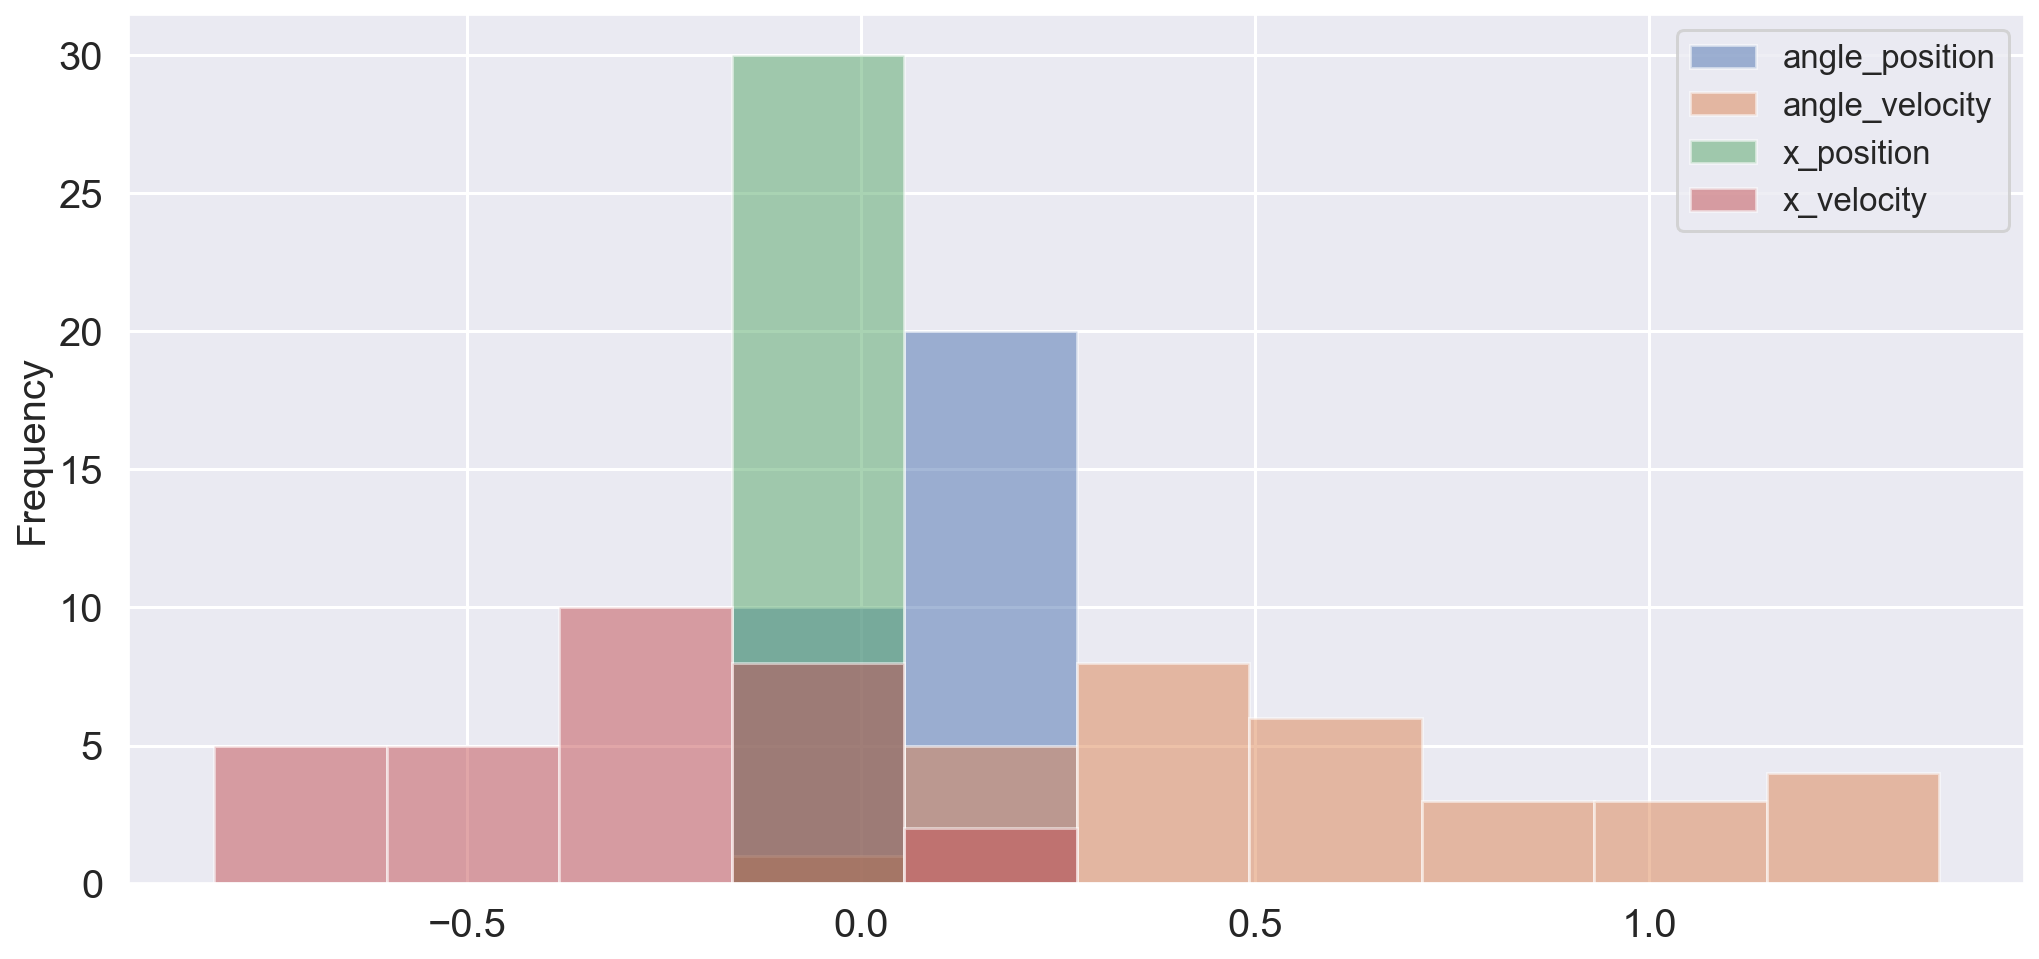

In [75]:
 plot_df = df.pivot_table(
     index=['IterationIndex'], 
     values= ['angle_position','angle_velocity', 'x_position','x_velocity']
    )
plot_df.plot(kind='hist',alpha=0.5)

## Iteration speed

In [76]:
plotdf = df
plotdf.index= df['Timestamp']
plotdf.iplot(
    subplots=True,
    shared_xaxes=True,
    title = 'vs Timestamp'
    )

plotdf['IterationSpeed_s'].iplot(
    title = 'IterationSpeed distribution',
    kind='hist',
    xTitle='IterationSpeed_s',
    yTitle='Count'
    )

## State trajectory for multiple episodes
TODO: Consider plotting considering vs SimConfig

In [77]:
plot_df = df.pivot(
    index=['IterationIndex'],
    columns = ['EpisodeIndex'],
    values = ['x_position', 'angle_position','x_velocity','angle_velocity'])
plot_df.head(10)

x_position                                                    \
EpisodeIndex         4.0       5.0       6.0       7.0       8.0       9.0    
IterationIndex                                                                
1.0                   NaN -0.037274  0.046273  0.022657 -0.022950 -0.043859   
2.0              0.032140 -0.037687  0.045994  0.022228 -0.023877 -0.043610   
3.0              0.027562 -0.042008  0.041818  0.025688 -0.028709 -0.047266   
4.0              0.019091 -0.050236  0.033742  0.033037 -0.029641 -0.054828   
5.0              0.006725 -0.054569  0.029571  0.044279 -0.034480 -0.058492   
6.0             -0.001734 -0.055010  0.021497  0.059416 -0.035420 -0.066065   
7.0             -0.014097 -0.051561  0.017323  0.078455 -0.040269 -0.077550   
8.0             -0.030364 -0.052026  0.009241  0.101399 -0.041222 -0.085145   
9.0             -0.050542 -0.056404 -0.002751  0.128256 -0.038279 -0.088855   
10.0            -0.074634 -0.064695 -0.010851  0.151229 -0.039248 -0.088685   

                                                        ... angle_velocity  \
EpisodeIndex        10.0      11.0      12.0      13.0  ...           7.0    
IterationIndex                                          ...                  
1.0            -0.040965  0.009916 -0.036944 -0.028784  ...      -0.038370   
2.0            -0.040187  0.010587 -0.036304 -0.029604  ...      -0.317125   
3.0            -0.043305  0.007363 -0.039560 -0.034320  ...      -0.596139   
4.0            -0.050317  0.000245 -0.038908 -0.042930  ...      -0.877248   
5.0            -0.053423 -0.010769 -0.034349 -0.055438  ...      -1.162245   
6.0            -0.052624 -0.025683 -0.033688 -0.071845  ...      -1.452853   
7.0            -0.055728 -0.036697 -0.036922 -0.092157  ...      -1.750691   
8.0            -0.062734 -0.051621 -0.044053 -0.108573  ...      -2.057233   
9.0            -0.065840 -0.070459 -0.055080 -0.121103  ...      -1.790573   
10.0           -0.065049 -0.085414 -0.070008 -0.137555  ...      -2.118520   

                                                                            \
EpisodeIndex        8.0       9.0       10.0      11.0      12.0      13.0   
IterationIndex                                                               
1.0            -0.003948 -0.028988  0.032628  0.021706 -0.013488 -0.040993   
2.0             0.291540  0.267036  0.317386  0.305388  0.272618  0.243972   
3.0             0.001662  0.562878  0.602359  0.589215 -0.026581  0.528673   
4.0             0.298941  0.275090  0.304125  0.875026 -0.324095  0.814957   
5.0             0.010936  0.576064  0.009635  1.164616 -0.036491  1.104630   
6.0             0.310076  0.878705  0.302424  0.874362  0.249023  1.399431   
7.0             0.024062  0.600072  0.595274  1.176630  0.534305  1.115912   
8.0            -0.259944  0.327299  0.304670  1.484112  0.821197  0.841594   
9.0             0.041314  0.058592  0.017873  1.214764  1.111506  1.158088   
10.0            0.340979  0.375351  0.318207  1.537508  1.406970  1.479265   

                                              
EpisodeIndex        14.0      15.0      16.0  
IterationIndex                                
1.0            -0.028558  0.042154 -0.026244  
2.0             0.269648  0.338287 -0.317769  
3.0            -0.017593  0.634681 -0.609461  
4.0             0.282102  0.933165 -0.317793  
5.0            -0.003516  0.650480 -0.615294  
6.0             0.297802  0.958468 -0.914751  
7.0             0.599095  1.270252 -0.632966  
8.0             0.902190  1.004382 -0.941669  
9.0             1.208866  1.328811 -1.254054  
10.0            0.936804  1.658557 -0.988770  

[10 rows x 52 columns]